In this notebook we try to create a PINN.

In [1]:
# %% Imports
import jax
from jax.ops import index, index_update
from jax import random, numpy as jnp
from flax import optim, linen as nn
from code import MLP, train_step, burgers, mse_loss

from time import time
from typing import Sequence
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [2]:
# Making dataset
x = jnp.linspace(-3, 4, 100)
t = jnp.linspace(0.5, 5.0, 20)

t_grid, x_grid = jnp.meshgrid(t, x, indexing='ij')
u = burgers(x_grid, t_grid, 0.1, 1.0)

X_train = jnp.concatenate([t_grid.reshape(-1, 1), x_grid.reshape(-1, 1)], axis=1)
y_train = u.reshape(-1, 1)

In [3]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, 1])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=1e-3)
optimizer = optimizer.create(params)

In [4]:
%%time
# Compiling train step
step = train_step(model, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 445 ms, sys: 124 ms, total: 569 ms
Wall time: 852 ms


In [5]:
%%time
# Running to convergence
max_epochs = 10001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 1000 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2440507858991623
Loss step 1000: 0.00044235572568140924
Loss step 2000: 0.00016897452587727457
Loss step 3000: 5.521780622075312e-05
Loss step 4000: 1.7329602997051552e-05
Loss step 5000: 7.9276469477918e-06
Loss step 6000: 4.9301042963634245e-06
Loss step 7000: 3.2835594083735486e-06
Loss step 8000: 2.256703737657517e-06
Loss step 9000: 1.973240159713896e-06
Loss step 10000: 2.663336090336088e-06
CPU times: user 4.21 s, sys: 205 ms, total: 4.42 s
Wall time: 4.15 s


In [6]:
# Getting params back out and plotting prediction
params = optimizer.target
y_pred = model.apply(params, X_train).reshape(x_grid.shape)

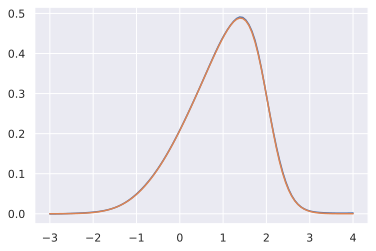

In [7]:
frame = -10
plt.plot(x, y_pred[frame, :])
plt.plot(x, u[frame, :])

Let's try and get some gradients:

In [8]:
def vgrad(f, x):
    y, vjp_fn = jax.vjp(f, x)
    return vjp_fn(jnp.ones(y.shape))[0]

In [9]:
# This beauty returns vector gradient
df = lambda y: vgrad(lambda x: model.apply(params, x), y)
dx = df(X_train)[:, [1]].reshape(x_grid.shape)
dt = df(X_train)[:, [0]].reshape(x_grid.shape)

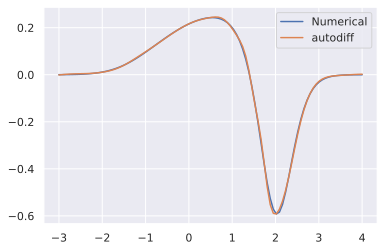

In [10]:
frame = 10
plt.plot(x, jnp.gradient(u[frame, :], jnp.diff(x)[0]), label='Numerical')
plt.plot(x, dx[frame, :], label='autodiff')
plt.legend()

In [11]:
d2f = lambda y: vgrad(lambda x: df(x)[:, [1]] , y)
d2x = d2f(X_train)[:, [1]].reshape(x_grid.shape)

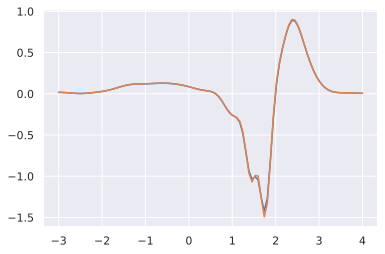

In [12]:
frame = 10
plt.plot(x, jnp.gradient(dx[frame, :], jnp.diff(x)[0]), label='Numerical')
plt.plot(x, d2x[frame, :], label='autodiff')

Both are correct :-). Now let's try and fit to see our results:

In [13]:
theta = jnp.concatenate([(y_pred * dx).reshape(-1, 1), d2x.reshape(-1, 1)], axis=1)
jnp.linalg.lstsq(theta, dt.reshape(-1, 1))[0]

DeviceArray([[-0.9721157 ],
             [ 0.09048073]], dtype=float32)

Perfect heujj :-). Let's try and code this up in a nice way:

In [14]:
def library_vjp(f, x):
    # First derivs
    df = lambda x: vgrad(f, x)
    d2f = lambda x: vgrad(lambda y: df(y)[:, [1]], x)
    d3f = lambda x: vgrad(lambda y: d2f(y)[:, [1]], x)
    
    u = jnp.concatenate([jnp.ones((x.shape[0], 1)), f(x), f(x)**2], axis=1)
    du = jnp.concatenate([jnp.ones((x.shape[0], 1)), df(x)[:, [1]], d2f(x)[:, [1]], d3f(x)[:, [1]]], axis=1)
    theta = (u[:, :, None] @ du[:, None, :]).reshape(-1, 12)
    return df(x)[:, [0]], theta

In [15]:
dt, theta = library_vjp(lambda x: model.apply(params, x), X_train)
theta = theta / jnp.linalg.norm(theta, axis=0, keepdims=True)

In [16]:
coeff, res = jnp.linalg.lstsq(theta, dt)[:2]
print(coeff, res)

[[-0.00637694]
 [-0.76496965]
 [ 5.125432  ]
 [ 0.4818009 ]
 [ 0.97914016]
 [-5.340505  ]
 [-3.3916807 ]
 [ 1.350407  ]
 [-1.925774  ]
 [-0.2156659 ]
 [ 1.731517  ]
 [-1.2934225 ]] [0.270134]


In [17]:
theta @ coeff

DeviceArray([[0.00053783],
             [0.00050614],
             [0.00047742],
             ...,
             [0.01335359],
             [0.00873375],
             [0.00481709]], dtype=float32)

Now that we have that, let's try to build a simple model discovery algo.

In [18]:
def train_step_pinn(model, library, x, y):
    """Constructs a fast update given a loss function.
    """
    def step(opt, x, y, model, library):
        def loss_fn(params):
            prediction = model.apply(params, x)
            dt, theta = library(lambda x: model.apply(params, x), x)
            coeff = jnp.linalg.lstsq(theta, dt)[0]
            loss = mse_loss(prediction, y) + mse_loss(dt, theta @ coeff)
            return loss

        grad_fn = jax.value_and_grad(loss_fn)
        loss, grad = grad_fn(opt.target)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss
    return jax.jit(lambda opt: step(opt, x, y, model, library))
  

In [19]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, 1])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [20]:
%%time
# Compiling train step
step = train_step_pinn(model, library_vjp, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 1.29 s, sys: 16.8 ms, total: 1.31 s
Wall time: 1.57 s


In [21]:
%%time
# Running to convergence
max_epochs = 20001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 500 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2500360906124115
Loss step 500: 0.0009721217211335897
Loss step 1000: 7.990280573721975e-05
Loss step 1500: 8.567446457163896e-06
Loss step 2000: 1.0991431054208078e-06
Loss step 2500: 4.788292926605209e-07
Loss step 3000: 4.234800030644692e-07
Loss step 3500: 3.051102908102621e-07
Loss step 4000: 2.164569252727233e-07
Loss step 4500: 1.350817058209941e-07
Loss step 5000: 2.5943194259525626e-07
Loss step 5500: 1.8167665416513046e-07
Loss step 6000: 1.52060607661042e-07
Loss step 6500: 1.0382630932781467e-07
Loss step 7000: 7.906231758170179e-08
Loss step 7500: 1.9169694098764012e-07
Loss step 8000: 7.659925671532619e-08
Loss step 8500: 1.2600577292687376e-07
Loss step 9000: 1.6101111555144598e-07
Loss step 9500: 1.4336922049551504e-07
Loss step 10000: 1.6467042485146521e-07
Loss step 10500: 9.647752818864319e-08
Loss step 11000: 1.8263354206737858e-07
Loss step 11500: 5.780108836006548e-08
Loss step 12000: 1.859539793258591e-07
Loss step 12500: 3.935935311005778e-08
Loss

Holy shit it worked and its fast. Let's check out the found coeffs:

In [22]:
prediction = model.apply(optimizer.target, X_train)
dt, theta = library_vjp(lambda x: model.apply(optimizer.target, x), X_train)
coeff = jnp.linalg.lstsq(theta, dt)[0]
normed_coeffs = coeff * jnp.linalg.norm(theta, axis=0, keepdims=True).T
mse = mse_loss(prediction, y_train)
reg = mse_loss(dt, theta @ coeff)

In [23]:
print('Normal coeffs, Normed coeffs')
print(jnp.concatenate([coeff, normed_coeffs], axis=1))

Normal coeffs, Normed coeffs
[[-5.09304809e-05 -2.27768044e-03]
 [-8.25747848e-04 -1.16824256e-02]
 [ 1.00115791e-01  5.09693956e+00]
 [ 3.48048052e-05  1.20427506e-02]
 [ 2.13601440e-03  2.27480344e-02]
 [-9.94973898e-01 -7.29859543e+00]
 [-2.19561905e-03 -8.45133960e-02]
 [ 9.32486728e-05  2.25404687e-02]
 [-5.79368323e-03 -3.57322097e-02]
 [-2.42251158e-03 -1.32236825e-02]
 [ 1.55589357e-03  5.97406290e-02]
 [-9.73735005e-05 -2.04612743e-02]]


In [24]:
mse

DeviceArray(9.2366e-08, dtype=float32)

In [25]:
reg

DeviceArray(1.9667075e-08, dtype=float32)

Now lets make a better more jax-like library. Let's get a baselinetime first:

In [26]:
%%timeit
prediction = model.apply(params, X_train)
dt, theta = library_vjp(lambda x: model.apply(params, x), X_train)

126 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
def vgrad(f, x):
    y, vjp_fn = jax.vjp(f, x)
    return vjp_fn(jnp.ones(y.shape))[0]

def library_vjp_v2(f, x):
    """library using only jvp"""
    # First derivs
    df = partial(vgrad, f)
    d2f = partial(vgrad, lambda y: df(y)[:, [1]])
    d3f = partial(vgrad, lambda y: d2f(y)[:, [1]])
    
    pred = f(x)
    dt, dx = df(x).T
    u = jnp.concatenate([jnp.ones_like(pred), pred, pred**2], axis=1)
    du = jnp.concatenate([jnp.ones_like(pred), dx[:, None], d2f(x)[:, [1]], d3f(x)[:, [1]]], axis=1)
    theta = (u[:, :, None] @ du[:, None, :]).reshape(-1, 12) # maybe rewrite using vmap?
    return pred, dt[:, None], theta

In [28]:
%%timeit
prediction, dt, theta = library_vjp_v2(partial(model.apply, params), X_train)

82.6 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's check with the new approach:

In [29]:
def train_step_pinn(model, library, x, y):
    """Constructs a fast update given a loss function.
    """
    def step(opt, x, y, model, library):
        def loss_fn(params, x, y, model, library):
            prediction, dt, theta = library(partial(model.apply, params), x)
            coeff, reg = jnp.linalg.lstsq(theta, dt)[:2]
            loss = mse_loss(prediction, y) + mse_loss(dt, theta @ coeff)
            return loss

        grad_fn = jax.value_and_grad(loss_fn, argnums=0)
        loss, grad = grad_fn(opt.target, x, y, model, library)
        opt = opt.apply_gradient(grad)  # Return the updated optimizer with parameters.
        return opt, loss
    return jax.jit(partial(step, x=x, y=y, model=model, library=library))

In [30]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, 1])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [31]:
%%time
# Compiling train step
step = train_step_pinn(model, library_vjp_v2, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 1.21 s, sys: 22.9 ms, total: 1.24 s
Wall time: 1.51 s


In [32]:
%%time
# Running to convergence
max_epochs = 20001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 500 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2500360906124115
Loss step 500: 0.0009721232345327735
Loss step 1000: 7.990275480551645e-05
Loss step 1500: 8.623226676718332e-06
Loss step 2000: 9.936284186551347e-07
Loss step 2500: 5.003069531994697e-07
Loss step 3000: 3.3556003131707257e-07
Loss step 3500: 2.9455651429088903e-07
Loss step 4000: 2.727873038566031e-07
Loss step 4500: 2.6577981770969927e-07
Loss step 5000: 1.9063411116349016e-07
Loss step 5500: 2.0476576878536434e-07
Loss step 6000: 1.4181334506702115e-07
Loss step 6500: 1.2948751759722654e-07
Loss step 7000: 1.3914674923398707e-07
Loss step 7500: 1.4074657883611508e-07
Loss step 8000: 1.0705179676051557e-07
Loss step 8500: 1.7980984523546795e-07
Loss step 9000: 1.3485225736076245e-07
Loss step 9500: 5.013939485820629e-08
Loss step 10000: 1.2064990073668014e-07
Loss step 10500: 6.115656248084633e-08
Loss step 11000: 1.8242445776195382e-07
Loss step 11500: 4.271370102060246e-08
Loss step 12000: 1.659665116449105e-07
Loss step 12500: 9.837033587700716e-08

In [33]:
prediction, dt, theta = library_vjp_v2(partial(model.apply, optimizer.target), X_train)
coeff, reg = jnp.linalg.lstsq(theta, dt)[:2]

In [34]:
print('Normal coeffs, Normed coeffs')
print(jnp.concatenate([coeff, normed_coeffs], axis=1))

Normal coeffs, Normed coeffs
[[ 1.82366348e-05 -2.27768044e-03]
 [-7.97167420e-04 -1.16824256e-02]
 [ 1.00028105e-01  5.09693956e+00]
 [-4.44252510e-06  1.20427506e-02]
 [ 4.12687659e-05  2.27480344e-02]
 [-9.94321465e-01 -7.29859543e+00]
 [-1.60413235e-03 -8.45133960e-02]
 [ 1.69134466e-04  2.25404687e-02]
 [-1.63202733e-03 -3.57322097e-02]
 [-4.10893559e-03 -1.32236825e-02]
 [ 1.29482150e-03  5.97406290e-02]
 [-1.45111233e-04 -2.04612743e-02]]


In [35]:
def vgrad_backward(f, x):
    y, vjp_fn = jax.vjp(f, x)
    return vjp_fn(jnp.ones(y.shape))[0]

def vgrad_forward(f, x, input_idx):
    s = index_update(jnp.zeros_like(x), index[:, input_idx], 1)
    _, jvp = jax.jvp(f, (x, ), (s, ))
    return jvp

In [36]:
f = partial(model.apply, params)

In [37]:
%%timeit
jax.jacfwd(f)(X_train).squeeze()[jnp.arange(2000), jnp.arange(2000),:]

54.6 ms ± 6.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
jax.jacrev(f)(X_train).squeeze()[jnp.arange(2000), jnp.arange(2000),:]

26.5 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
df = partial(vgrad_backward, f)
df(X_train)

DeviceArray([[ 0.23383658,  0.01322598],
             [ 0.23809928,  0.01492578],
             [ 0.24255228,  0.01667295],
             ...,
             [ 0.02961195, -0.04275975],
             [ 0.04485619, -0.05898526],
             [ 0.06141977, -0.07693255]], dtype=float32)

In [40]:
d2f_forward = partial(vgrad_forward, lambda y: df(y)[:, [1]], input_idx=1)
d2f_backward = partial(vgrad, lambda y: df(y)[:, [1]])

In [41]:
jnp.max(jnp.abs(d2f_forward(X_train) - d2f_backward(X_train)[:, [1]]))

DeviceArray(3.5762787e-07, dtype=float32)

In [42]:
d3f_forward = partial(vgrad_forward, d2f_forward, input_idx=1)
d3f_backward = partial(vgrad, lambda y: d2f_backward(y)[:, [1]])

In [43]:
jnp.max(jnp.abs(d3f_forward(X_train) - d3f_backward(X_train)[:, [1]]))

DeviceArray(1.9073486e-06, dtype=float32)

In [44]:
def library_jvp(f, x):
    # First derivs
    df = partial(vgrad_backward, f)
    d2f = partial(vgrad_forward, lambda y: df(y)[:, [1]], input_idx=1)
    d3f = partial(vgrad_forward, d2f, input_idx=1)
    
    pred = f(x)
    dt, dx = df(x).T
    u = jnp.concatenate([jnp.ones_like(pred), pred, pred**2], axis=1)
    du = jnp.concatenate([jnp.ones_like(pred), dx[:, None], d2f(x), d3f(x)], axis=1)
    theta = (u[:, :, None] @ du[:, None, :]).reshape(-1, 12) # maybe rewrite using vmap?
    return pred, dt[:, None], theta

In [45]:
prediction, dt, theta = library_jvp(partial(model.apply, optimizer.target), X_train)
coeff, reg = jnp.linalg.lstsq(theta, dt)[:2]

In [46]:
coeff

DeviceArray([[ 1.8218358e-05],
             [-7.9707801e-04],
             [ 1.0002824e-01],
             [-4.4262270e-06],
             [ 4.1224062e-05],
             [-9.9432158e-01],
             [-1.6043894e-03],
             [ 1.6903225e-04],
             [-1.6316883e-03],
             [-4.1103363e-03],
             [ 1.2949333e-03],
             [-1.4509261e-04]], dtype=float32)

So it seems to work... Now to check speed:

In [47]:
# Instantiating model and optimizers
model = MLP(features=[50, 50, 1])
key = random.PRNGKey(42)
params = model.init(key, X_train[[0], :])
optimizer = optim.Adam(learning_rate=2e-3, beta1=0.99, beta2=0.99)
optimizer = optimizer.create(params)

In [48]:
%%time
# Compiling train step
step = train_step_pinn(model, library_jvp, X_train, y_train)
_ = step(optimizer)  # triggering compilation

CPU times: user 1.03 s, sys: 15.2 ms, total: 1.05 s
Wall time: 1.32 s


In [49]:
%%time
# Running to convergence
max_epochs = 20001
for i in jnp.arange(max_epochs):
    optimizer, loss = step(optimizer)
    if i % 500 == 0:
        print(f"Loss step {i}: {loss}")

Loss step 0: 0.2500360906124115
Loss step 500: 0.0009721241076476872
Loss step 1000: 7.990286394488066e-05
Loss step 1500: 8.626499038655311e-06
Loss step 2000: 9.819325441640103e-07
Loss step 2500: 5.288015358928533e-07
Loss step 3000: 3.1234048947226256e-07
Loss step 3500: 2.4742030291236006e-07
Loss step 4000: 1.7579881728124747e-07
Loss step 4500: 2.3105062041395286e-07
Loss step 5000: 1.8019561309756682e-07
Loss step 5500: 2.1414425077637134e-07
Loss step 6000: 1.470313577556226e-07
Loss step 6500: 9.047307969467511e-08
Loss step 7000: 1.539709586495519e-07
Loss step 7500: 1.3538253540446021e-07
Loss step 8000: 8.027816988942504e-08
Loss step 8500: 1.8620033870320185e-07
Loss step 9000: 2.1618696166569862e-07
Loss step 9500: 1.4008381299390749e-07
Loss step 10000: 1.1328880589189794e-07
Loss step 10500: 3.959320338253747e-08
Loss step 11000: 1.9121760885809636e-07
Loss step 11500: 9.33069230768524e-08
Loss step 12000: 1.3494677375547326e-07
Loss step 12500: 3.3750698236190146e-08


In [53]:
dt, theta = library_vjp(partial(model.apply, optimizer.target), X_train)
coeff_vjp = jnp.linalg.lstsq(theta, dt)[0]

prediction, dt, theta = library_vjp_v2(partial(model.apply, optimizer.target), X_train)
coeff_vjp_v2 = jnp.linalg.lstsq(theta, dt)[0]

prediction, dt, theta = library_jvp(partial(model.apply, optimizer.target), X_train)
coeff_jvp = jnp.linalg.lstsq(theta, dt)[0]


Let's compare all the libraries to be sure it's correct.

In [57]:
print('Original VJP | Fast VJP | JVP')
jnp.concatenate([coeff_vjp, coeff_vjp_v2, coeff_jvp], axis=1)

Original VJP | Fast VJP | JVP


DeviceArray([[ 4.38657589e-05,  4.38657589e-05,  4.38431744e-05],
             [-7.81595707e-04, -7.81595707e-04, -7.81543553e-04],
             [ 1.00044645e-01,  1.00044645e-01,  1.00044809e-01],
             [-1.18543394e-05, -1.18543394e-05, -1.18330354e-05],
             [-4.84231859e-04, -4.84231859e-04, -4.84231859e-04],
             [-9.93874848e-01, -9.93874848e-01, -9.93874609e-01],
             [-1.56688690e-03, -1.56688690e-03, -1.56672671e-03],
             [ 1.90493185e-04,  1.90493185e-04,  1.90485502e-04],
             [-5.90365380e-04, -5.90365380e-04, -5.89791685e-04],
             [-4.72807884e-03, -4.72807884e-03, -4.72804904e-03],
             [ 1.29665807e-03,  1.29665807e-03,  1.29637495e-03],
             [-1.61418691e-04, -1.61418691e-04, -1.61374453e-04]],            dtype=float32)